Домашнее задание по результатам 3 вебинара.  

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции   
 y = sin(x)x - x10  
При выполнении данного задания структура GAN остается той же, но Вам нужно:  
Сгенерировать настоящие данные  
Изменить архитектуру дискриминатора и генератора  
Без графиков домашку не принимаю  
(*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как описано в оригинальной статье. И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться официальной статьей от pytorch. 

In [1]:

import numpy as np
import math

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt


In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
def f(x):
    return np.sin(x)*x-10*x


In [299]:
x = np.linspace(-100,100,1000000)
y = f(x)
data = np.column_stack((x,y))
data.shape

(1000000, 2)

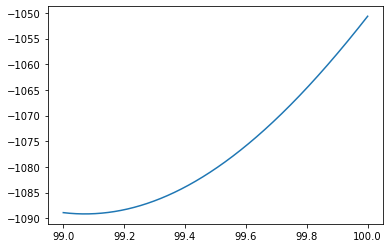

In [300]:

plt.plot(data[-5000:-1,0],data[-5000:-1,1])
plt.show()

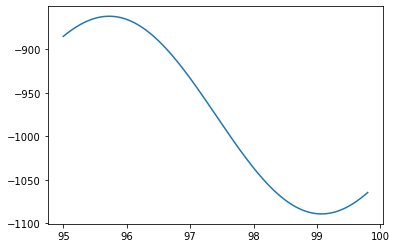

In [303]:

plt.plot(data[-25000:-1000,0],data[-25000:-1000,1])
plt.show()

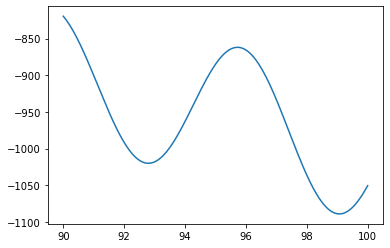

In [304]:

plt.plot(data[-50000:-1,0],data[-50000:-1,1])
plt.show()

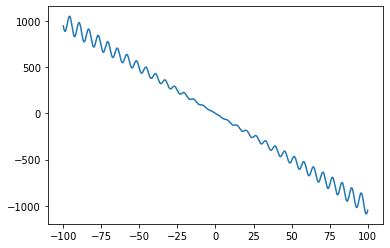

In [305]:

plt.plot(data[:,0],data[:,1])
plt.show()

In [306]:
data.shape

(1000000, 2)

In [100]:
class CustomDataset(Dataset):
    def __init__(self, x):
        self.data_info = x
        self.data_len = len(self.data_info)
        
    def __getitem__(self, index):
        x= self.data_info[index]
        return (x)

    def __len__(self):
        return self.data_len

In [307]:
train_data = CustomDataset(data)


In [308]:
train_data_loader = DataLoader(train_data,batch_size=1000,shuffle=True)


In [309]:
sample = iter(train_data_loader).next()

In [310]:
sample.shape

torch.Size([1000, 2])

In [311]:
class Generator(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)],
                ['sigmoid',nn.Sigmoid()]])
        
        Liner = nn.Linear
        self.model = nn.Sequential(
                        Liner(latent_dim,256),
                        nn.Dropout(0.2),
                        nn.BatchNorm1d(256),
                        activations['sigmoid'],
                        Liner(256,512),
                        nn.Dropout(0.2),
                        nn.BatchNorm1d(512),
                        activations['relu'],
                        Liner(512,1024),
                        nn.Dropout(0.3),
                        nn.BatchNorm1d(1024),
                        activations['relu'],
                        Liner(1024,2048),
                        nn.Dropout(0.4),
                        nn.BatchNorm1d(2048),
                        activations['relu'],
                        Liner(2048,2)
                                    )

    def forward(self, z):
        data = self.model(z)
        return data

In [312]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)],
                ['sigmoid',nn.Sigmoid()]])
        
        Liner = nn.Linear
        
        self.model = nn.Sequential(
            Liner(2, 512),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512),
            activations['sigmoid'],
            Liner(512, 1024),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),
            activations['lrelu'],
            Liner(1024, 512),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            activations['lrelu'],
            Liner(512, 1),  
            activations['sigmoid'],
        )
  

    def forward(self, z):
        validity = self.model(z)
        return validity

In [329]:
n_epochs = 25 # количество эпох
lr = 0.0005 # шаг обучения
# b1 = 0.5 # гиперпараметр для оптимайзера Adam
# b2 = 0.999 # гиперпараметр для оптимайзера Adam
latent_dim = 50 # Размерность случайного вектора, который подается на вход генератору


In [330]:
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)


# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [331]:
d_loss_history = []
g_loss_history = []

In [332]:
for epoch in range(n_epochs):
    for i, x_data in enumerate(train_data_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        batch_size = x_data.size(0)
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_data = x_data.type(torch.FloatTensor).to(device)
        
######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_data.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
    pred = gen_data.cpu()
    pred = pred.detach().numpy()
    mae = np.mean(np.abs(pred[:,1]-f(pred[:,0])))       
    err = np.mean(np.abs(pred[:,1]-f(pred[:,0]))/np.abs(f(pred[:,0])))
    
    print(f'Эпоха: {epoch},d_loss: {d_loss}, g_loss {g_loss},mae:{mae},относительная абс. ошибка: {err} ')

Эпоха: 0,d_loss: 0.27904829382896423, g_loss 2.175856113433838,mae:13.841849327087402,относительная абс. ошибка0.27345359325408936 
Эпоха: 1,d_loss: 0.390704870223999, g_loss 1.9538583755493164,mae:24.7849178314209,относительная абс. ошибка0.15143540501594543 
Эпоха: 2,d_loss: 0.768639326095581, g_loss 1.1055166721343994,mae:38.83393096923828,относительная абс. ошибка0.14618530869483948 
Эпоха: 3,d_loss: 0.47415101528167725, g_loss 1.2037456035614014,mae:42.354957580566406,относительная абс. ошибка0.13771852850914001 
Эпоха: 4,d_loss: 0.7448863983154297, g_loss 0.7182300090789795,mae:41.39403533935547,относительная абс. ошибка0.12538716197013855 
Эпоха: 5,d_loss: 0.7001364827156067, g_loss 0.6902559995651245,mae:36.85324478149414,относительная абс. ошибка0.10253862291574478 
Эпоха: 6,d_loss: 0.691261887550354, g_loss 0.6912925243377686,mae:41.58127975463867,относительная абс. ошибка0.1168757826089859 
Эпоха: 7,d_loss: 0.6970531940460205, g_loss 0.6886560916900635,mae:37.959102630615234

In [345]:
z = torch.FloatTensor(np.random.normal(0, 1, (100, latent_dim))).to(device)

In [346]:
pred = generator(z).cpu()
pred = pred.detach().numpy()

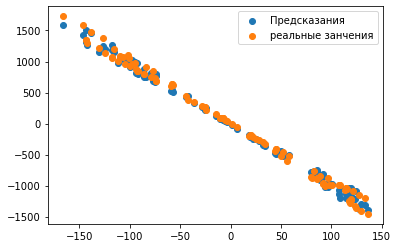

In [347]:
plt.scatter(pred[:,0],pred[:,1],label='Предсказания')
plt.scatter(pred[:,0],f(pred[:,0]), label = 'реальные занчения')
plt.legend()
plt.show()

In [348]:
err = np.mean(np.abs(pred[:,1]-f(pred[:,0]))/np.abs(f(pred[:,0])))
err

0.112796046

Вторая часть

In [358]:
img_size = 28 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 32 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки

real_data = DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,num_workers=2
)

img_shape = (1, 28, 28)
lable_shape = torch.Size([])
img_shape after squeeze = (28, 28)
Значения: tensor([6, 7, 3])


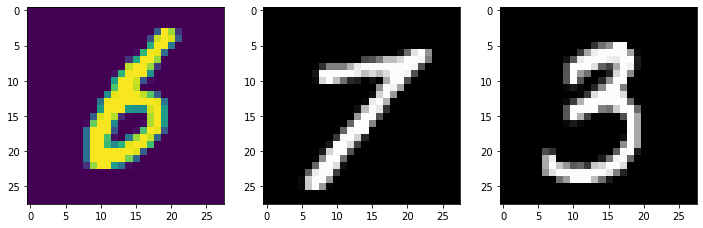

In [359]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img)
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')
print(f'Значения: {labels[:3]}')

In [360]:
import torchvision.utils as vutils

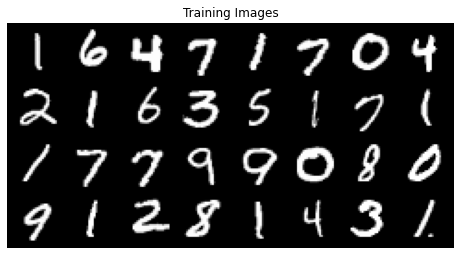

In [367]:
real_batch = dataiter.next()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [368]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)